# Generalized Linear Models

A [Generalized Linear Model](https://en.wikipedia.org/wiki/Generalized_linear_model) (GLM), not to be confused with a [General Linear Model](https://en.wikipedia.org/wiki/General_linear_model), is a regression model that trains a filter to model single neuron activity as it relates to some other variable. For example, to predict the spike counts produced by a single neuron (Y) in response to licking events (X). The GLM model can be represented by the following equation:
$y(t) = Poiss(f(k * X_{t}))$, where `Poiss` is a poisson process and `f` is a non-linearity function, in this case $f(x) = e^x$

To train a GLM, we start by creating a *design matrix* from the visual stimulus. The design matrix is the input, X_train, provided to the GLM for training along with known spike counts in each trial, Y_train. The GLM uses [Maximum Likelihood Estimation](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation) to train the filter vector that maximizes the likelihood of producing a given spike train from the inputted design matrix. To predict the spike activity of a neuron, the filter is first convolved with the stimulus vector. Next, the GLM employs a non-linearity step (exponential in this case), followed by poisson generation to generate specific spike counts as shown in the figure below.

This notebook demonstrates the usage of a Poisson GLM to model and reproduce the spiking activity of single neurons in response to a visual stimulus. GLMs are trained using synthetic data, as well as real data from the Allen Institute `Visual Coding - Neuropixels` dataset.

For more information on applying GLMs for predicting spiking activity, see the Pillow Lab's [GLM Slides](https://github.com/pillowlab/GLMspiketraintutorial/tree/master/slides) and Neuromatch Academy's [GLM tutorial](https://compneuro.neuromatch.io/tutorials/W1D3_GeneralizedLinearModels/student/W1D3_Tutorial1.html).

![glm.png](../../data/images/glm.png)

Modified from Slide 6, *[Generalized linear models for cracking the neural code](https://pillowlab.princeton.edu/pubs/pillow_TutorialSlides_Cosyne2018.pdf)*, Pillow Lab

### Environment Setup

In [1]:
try:
    from databook_utils.dandi_utils import dandi_download_open
except:
    !git clone https://github.com/AllenInstitute/openscope_databook.git
    %cd openscope_databook
    %pip install -e .

In [2]:
import os
import numpy as np

import matplotlib.pyplot as plt
import statsmodels.api as sm

from math import ceil
from scipy import interpolate
from functools import reduce

from scipy.optimize import minimize
from sklearn.metrics import r2_score

%matplotlib inline

### Downloading File

In [3]:
dandiset_id = "000021"
dandi_filepath = "sub-726298249/sub-726298249_ses-754829445.nwb"
download_loc = "."

In [4]:
io = dandi_download_open(dandiset_id, dandi_filepath, download_loc)
nwb = io.read()

A newer version (0.60.0) of dandi/dandi-cli is available. You are using 0.55.1


File already exists
Opening file


C:\Users\carter.peene\AppData\Roaming\Python\Python39\site-packages\hdmf\utils.py:668: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  return func(args[0], **pargs)
C:\Users\carter.peene\AppData\Roaming\Python\Python39\site-packages\hdmf\utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.2.2 because version 2.6.0-alpha is already loaded.
  return func(args[0], **pargs)


### The GLM
The functions below are used in training the GLM. 


The function `fit_lnp` takes in the *design_matrix* ~as~, `X`, produced from the stimulus and the observed spike counts, `y`. It also takes the length of the filter to train, `d`, and the regularization coefficient, `lam`,. First, the function initializes a random filter of length `d` and then uses the `neg_log_like_lnp` function to perform Maximum Likelihood Estimation to train the filter. 

`neg_log_lik_lnp` computes the negative log likelihood for a vector of filter weights `theta`, the design matrix `X`, and the observed spike counts, `y`. The `Cinv` matrix, a diagonal matrix with the regularization coefficient, is applied for regularization. It would also help to explain each function by its inputs and outputs.

The `predict` function perform the inverse operation, applying a trained filter `weights` to the *design matrix* `X`, and adding a constant, yielding the spike probability over time. 

`predict_spikes` takes the spike rate prediction and runs it through Poisson generation, adding noise and producing a set of predicted spike counts. Because the poisson generation is non-deterministic, it will produce different results every time.

This code was adapted from [this code](https://github.com/pillowlab/GLMspiketraintutorial/tree/master) from the Pillow Lab, with the regularization code from [this tutorial](https://compneuro.neuromatch.io/tutorials/W1D3_GeneralizedLinearModels/student/W1D3_Tutorial1.html) from Neuromatch Academy.

In [5]:
def neg_log_lik_lnp(theta, X, y, Cinv):
  # Compute the Poisson log likelihood
  rate = np.exp(X @ theta)
  log_lik = y @ np.log(rate) - rate.sum()
  log_lik -= theta.T @ Cinv @ theta

  return -log_lik

In [6]:
def fit_lnp(X, y, d=25, lam=0):
  Imat = np.identity(d+1) # identity matrix of size of filter + const
  Imat[0,0] = 0
  Cinv = lam*Imat

  # Use a random vector of weights to start (mean 0, sd .2)
  x0 = np.random.normal(0, .2, d + 1)
  print("y:",y.shape,"X:",X.shape,"x0:",x0.shape)

  # Find parameters that minimize the negative log likelihood function
  res = minimize(neg_log_lik_lnp, x0, args=(X, y, Cinv))

  return res["x"]

In [7]:
def predict(X, weights, constant):
    y = np.exp(X @ weights + constant)
    return y

def predict_spikes(X, weights, constant):
    rate = predict(X, weights, constant)
    spks = np.random.poisson(np.matrix.transpose(rate))
    return spks

### Synthetic Data
The cells below prepare the synthetic data (stimulus and spiking data), and show how to train a GLM. 

`make_flashes` produces boxcar stimulus that imitate binary flashes. 

`make_spikes` utilizes the same mathematics as the GLM's prediction and generates spikes that have a direct relationship with the brightness of the synthetic stimulus. It simply multiplies the stimulus by a given coefficient `coeff`, and adds a given constant, `baseline_rate`. It runs the resulting rate through exponentiation and then generates Poission distributed spike counts with this as the spiking probability.

0.0 300.0
30000


Text(0, 0.5, "'Brightness'")

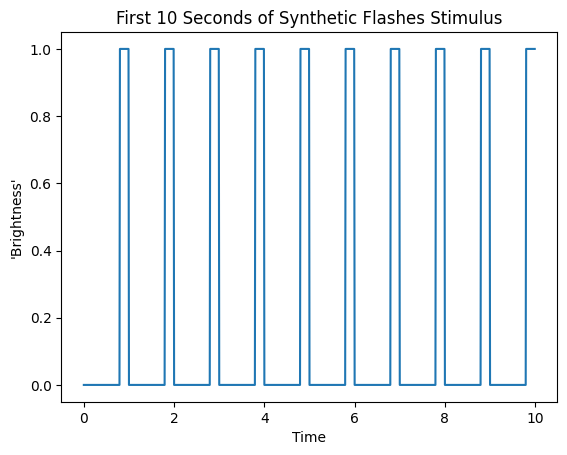

In [8]:
def make_flashes(time_start, time_end, pattern, n_repeats):
    flashes = np.tile(pattern, n_repeats)
    time_axis = np.linspace(time_start, time_end, len(flashes))
    return time_axis, flashes

syn_time_axis, syn_flashes = make_flashes(0, 300, [0]*80 + [1]*20, 300)
print(syn_time_axis[0], syn_time_axis[-1])
print(len(syn_flashes))

plt.plot(syn_time_axis[:1000], syn_flashes[:1000])
plt.title("First 10 Seconds of Synthetic Flashes Stimulus")
plt.xlabel("Time")
plt.ylabel("'Brightness'")

0.1353352832366127 0.0820849986238988
30000


Text(0, 0.5, '# Spikes')

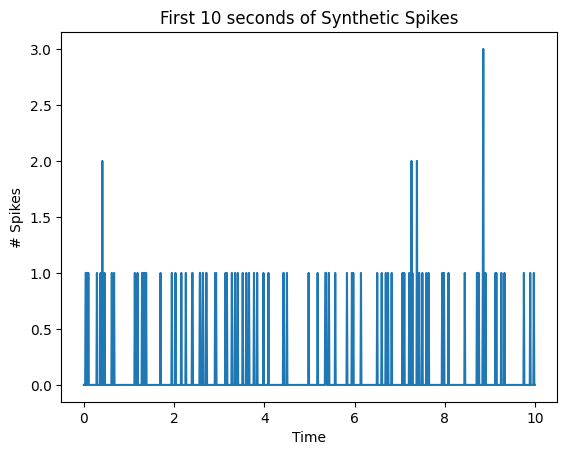

In [9]:
def make_spikes(stim, baseline_rate, coeff, return_exp=False):
    weighted_stim = (stim*coeff) + baseline_rate
    exp_stim = np.exp(weighted_stim)
    print(np.max(exp_stim), np.min(exp_stim))
    spikes = np.random.poisson(exp_stim)
    if return_exp:
        return spikes, weighted_stim, exp_stim
    return spikes

# set with parameters -2.5 and 0.5, the GLM should learn these parameters
syn_spikes, syn_weight, syn_exp = make_spikes(syn_flashes, -2.5, 0.5, return_exp=True)
print(len(syn_spikes))

plt.plot(syn_time_axis[:1000], syn_spikes[:1000])
plt.title("First 10 seconds of Synthetic Spikes")
plt.xlabel("Time")
plt.ylabel("# Spikes")

### Design Matrix
The GLM takes in the following *design matrix* to conduct Maximum Likelihood Estimation. The design matrix must have dimensions `time` * `d`, where time is the length of the stimulus, and d is the length of the filter to be trained. It can be seen below that it is simply slices of the `d` most recent stimulus values for each timepoint in the stimulus. Importantly, a GLM also yields a `constant` value with each filter. This constant term is the bias term that captures the spike count variance unexplained by the input variables. For this, we simply add a 1 to each row in the design matrix. The resulting column of 1s produces the bias term from the MLE.

The function `build_design_matrix` returns such a design_matrix from a given `stim` array and a filter length `d`.

In [10]:
def build_design_mat(stim, d):
  constant = np.ones_like(stim)

  # Create version of stimulus vector with zeros before onset
  padded_stim = np.concatenate([np.zeros(d - 1), stim])

  # Construct a matrix where each row has the d frames of
  # the stimulus preceding and including timepoint t
  T = len(stim)  # Total number of timepoints (hint: number of stimulus frames)
  X = np.zeros((T, d))
  for t in range(T):
      X[t] = padded_stim[t:t + d]

  design_matrix = np.column_stack([constant, X])
  return design_matrix

(30000, 26)


Text(0, 0.5, 'Time (through session)')

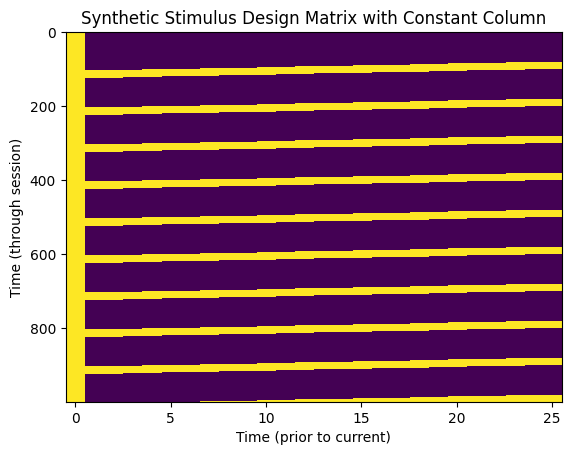

In [11]:
syn_design_mat = build_design_mat(syn_flashes, 25)
print(syn_design_mat.shape)
plt.imshow(syn_design_mat[:1000], aspect="auto", interpolation="none")
plt.title("Synthetic Stimulus Design Matrix with Constant Column")
plt.xlabel("Time (prior to current)")
plt.ylabel("Time (through session)")

### Running on Synthetic Data
Below is an example of a trained GLM filter trained using a filter length of 25 and a regularization coefficient of $2^{10}$. During prediction, this filter would be convolved with the design matrix before undergoing the expontential non-linearity step to produce spike rate.

y: (30000,) X: (30000, 26) x0: (26,)
-2.4259304193492475


Text(0, 0.5, 'Unitless')

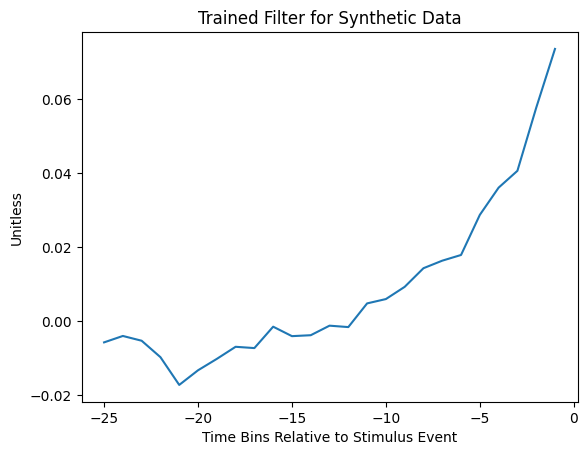

In [12]:
res = fit_lnp(syn_design_mat, syn_spikes, d=25, lam=2**10)
constant, filter = res[0], res[1:]
print(constant)
plt.plot(range(-len(filter),0), filter)
plt.title("Trained Filter for Synthetic Data")
plt.xlabel("Time Bins Relative to Stimulus Event")
plt.ylabel("Unitless")

### Testing Model

To get a sense of how the GLM performs on synthetic data, the function `test_synthetic_glm` is used to yield a constant and a filter of length 1. Since the synthetic spikes were produced with a constant `baseline_rate` and a coefficient `coeff`, we should expect the GLM to effectively reproduce these values in the constant and length 1 filter. The GLM performance is tested by iterating over successive values of regularization coefficient `lam` and the number of repeats of stimulus flashes, `n_repeats`, both ranging between 1 and $2^9$. The optimal values for these variables are obtained by maximixing the [Coefficient of Determination](https://en.wikipedia.org/wiki/Coefficient_of_determination) $R^2$. The results below indicate that as the regularization coefficient increases, the GLM performance starts to suffer. This is because higher regularization values promote a stronger tendency for trained filter values to stay closer to 0, limiting the MLE's ability to fit a model effectively. They also indicate that the GLM performance converges toward the real constant and coefficient values as the number of repeats of the stimulus increases because there is more data to train with.

In [13]:
def test_synthetic_glm(constant_in, coeff_in, flashes, constants, filters, r2s, lam=0, d=1):
    design_mat = build_design_mat(flashes, d=d)
    syn_spikes, syn_weights, syn_prob = make_spikes(flashes, constant_in, coeff_in, return_exp=True)

    res = fit_lnp(design_mat, syn_spikes, d=d, lam=lam)
    const, filt = res[0], res[1:]

    prob_predicted = predict(design_mat[:,1:], filt, const)
    spikes_predicted = predict_spikes(design_mat[:,1:], filt, const)
    r2 = r2_score(syn_spikes, prob_predicted)

    constants.append(const)
    filters.append(filt)
    r2s.append(r2)

In [14]:
repeats_vals = []
r_coeffs = []
r_constants = []
r_r2s = []

for i in range(10):
    n_repeats = 2**i
    time_axis, syn_flashes = make_flashes(0, n_repeats, [0]*80 + [1]*20, n_repeats)

    for j in range(10):
        test_synthetic_glm(-2.3, 2.3, syn_flashes, r_constants, r_coeffs, r_r2s)
        repeats_vals.append(n_repeats)

lambda_vals = []
l_coeffs = []
l_constants = []
l_r2s = []

time_axis, syn_flashes = make_flashes(0, 2**8, [0]*80 + [1]*20, 2**8)
design_mat = build_design_mat(syn_flashes, d=1)
for i in range(10):
    lam = 2**i

    for j in range(10):
        test_synthetic_glm(-2.3, 2.3, syn_flashes, l_constants, l_coeffs, l_r2s, lam=lam)
        lambda_vals.append(lam)

1.0 0.10025884372280375
y: (100,) X: (100, 2) x0: (2,)
1.0 0.10025884372280375
y: (100,) X: (100, 2) x0: (2,)
1.0 0.10025884372280375
y: (100,) X: (100, 2) x0: (2,)
1.0 0.10025884372280375
y: (100,) X: (100, 2) x0: (2,)
1.0 0.10025884372280375
y: (100,) X: (100, 2) x0: (2,)
1.0 0.10025884372280375
y: (100,) X: (100, 2) x0: (2,)
1.0 0.10025884372280375
y: (100,) X: (100, 2) x0: (2,)
1.0 0.10025884372280375
y: (100,) X: (100, 2) x0: (2,)
1.0 0.10025884372280375
y: (100,) X: (100, 2) x0: (2,)
1.0 0.10025884372280375
y: (100,) X: (100, 2) x0: (2,)
1.0 0.10025884372280375
y: (200,) X: (200, 2) x0: (2,)
1.0 0.10025884372280375
y: (200,) X: (200, 2) x0: (2,)
1.0 0.10025884372280375
y: (200,) X: (200, 2) x0: (2,)
1.0 0.10025884372280375
y: (200,) X: (200, 2) x0: (2,)
1.0 0.10025884372280375
y: (200,) X: (200, 2) x0: (2,)
1.0 0.10025884372280375
y: (200,) X: (200, 2) x0: (2,)
1.0 0.10025884372280375
y: (200,) X: (200, 2) x0: (2,)
1.0 0.10025884372280375
y: (200,) X: (200, 2) x0: (2,)
1.0 0.1002

Text(0, 0.5, '$R^2$')

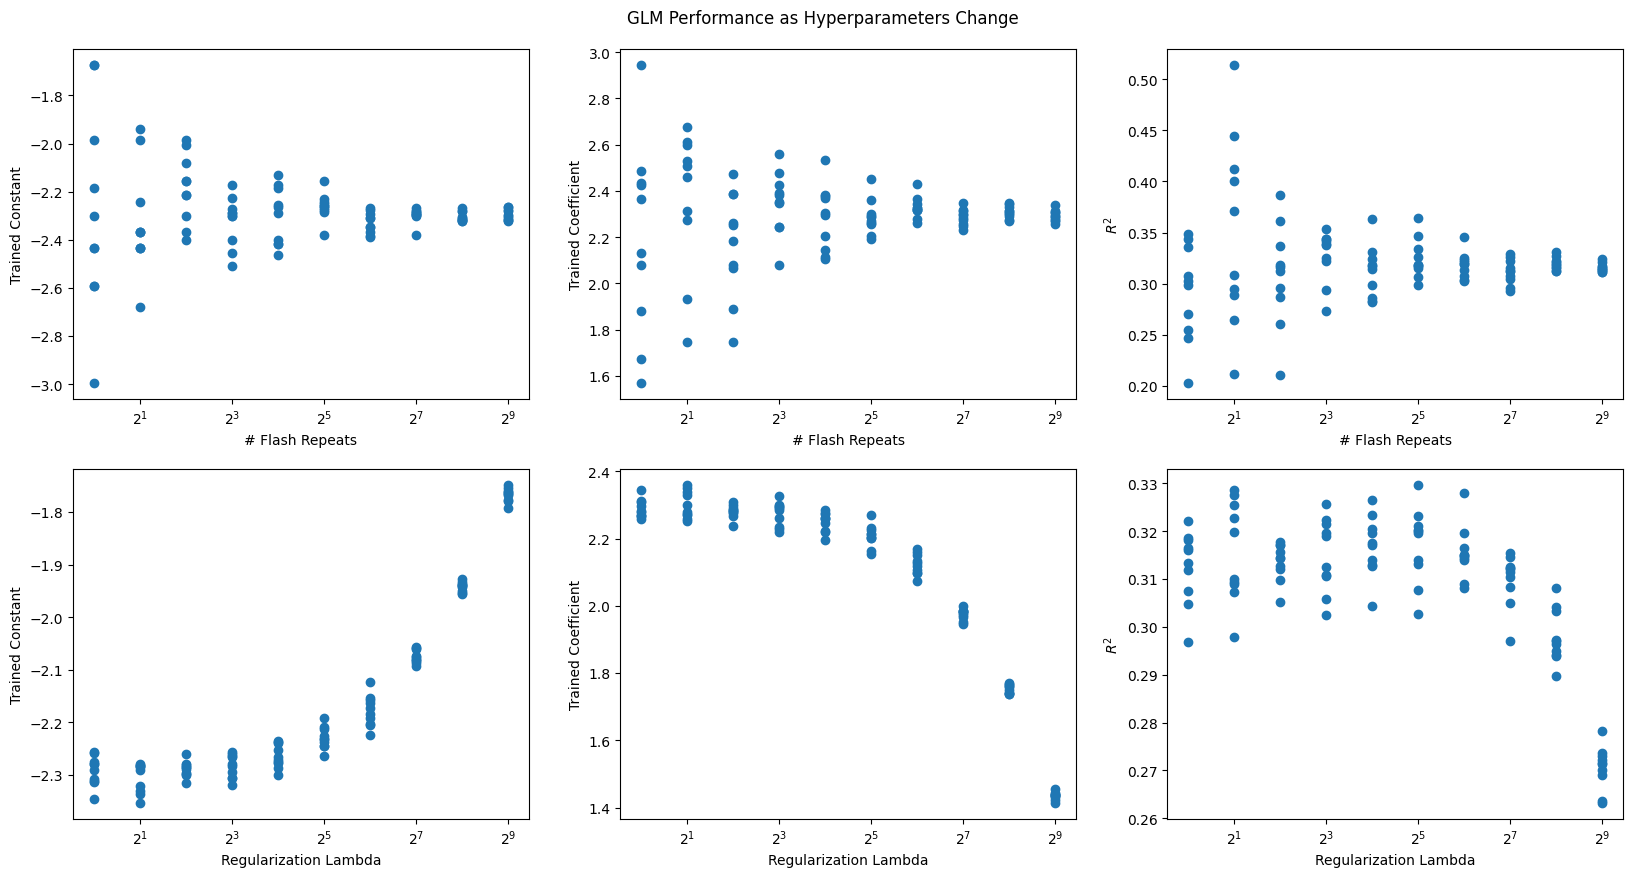

In [15]:
fig, axes = plt.subplots(2, 3, figsize=(20,10))
fig.suptitle("GLM Performance as Hyperparameters Change", y=0.92)
for ax in axes.flatten()[:6]:
    ax.set_xscale("log", base=2)

axes[0][0].scatter(repeats_vals, r_constants)
axes[0][0].set_xlabel("# Flash Repeats")
axes[0][0].set_ylabel("Trained Constant")

axes[0][1].scatter(repeats_vals, r_coeffs)
axes[0][1].set_xlabel("# Flash Repeats")
axes[0][1].set_ylabel("Trained Coefficient")

axes[0][2].scatter(repeats_vals, r_r2s)
axes[0][2].set_xlabel("# Flash Repeats")
axes[0][2].set_ylabel("$R^2$")

axes[1][0].scatter(lambda_vals, l_constants)
axes[1][0].set_xlabel("Regularization Lambda")
axes[1][0].set_ylabel("Trained Constant")

axes[1][1].scatter(lambda_vals, l_coeffs)
axes[1][1].set_xlabel("Regularization Lambda")
axes[1][1].set_ylabel("Trained Coefficient")

axes[1][2].scatter(lambda_vals, l_r2s)
axes[1][2].set_xlabel("Regularization Lambda")
axes[1][2].set_ylabel("$R^2$")

## Real Data - Allen Institute Visual Coding dataset

### Extracting Spike Data
After examining the GLM on synthetic data to empirically evaluate hyperparameters, we test GLM performance on real data. First, desirable units are selected from the NWB File. Here, neurons are chosen from the primary visual cortex `VISp`. For convenience, the list of regions in this NWB file are displayed below. `brain_regions` can be altered to suit your preferences. Only units of "good" quality and a firing rate greater than 2 are selected. More information on unit quality metrics can be found in [Visualizing Unit Quality Metrics ](../visualization/visualize_unit_metrics.ipynb)

In [16]:
units = nwb.units

In [17]:
### use the electrodes table to devise a function which maps units to their brain regions

# select electrodes
channel_probes = {}

electrodes = nwb.electrodes
for i in range(len(electrodes)):
    channel_id = electrodes["id"][i]
    location = electrodes["location"][i]
    channel_probes[channel_id] = location

# function aligns location information from electrodes table with channel id from the units table
def get_unit_location(row):
    return channel_probes[int(row.peak_channel_id)]

all_regions = set(get_unit_location(row) for row in units)
print(all_regions)

{'', 'CA2', 'CA1', 'DG', 'LGd', 'PoT', 'CA3', 'VPM', 'PO', 'VISpm', 'APN', 'POL', 'LP', 'VISp', 'Eth', 'VISrl', 'TH', 'VISam'}


In [18]:
### selecting units spike times

brain_regions = ["VISp"]

# select units based if they have 'good' quality and exists in one of the specified brain_regions
units_spike_times = []
for location in brain_regions:
    location_units_spike_times = []
    for row in units:
        if get_unit_location(row) == location and row.quality.item() == "good" and row.firing_rate.item() > 2.0:
            location_units_spike_times.append(row.spike_times.item())
    units_spike_times += location_units_spike_times

print(len(units_spike_times))

124


### Extracting Real Flashes Data

Next, we retrieve the stimulus information (full-field flashes) from the dataset.
To ensure they have a regular timescale, they are interpolated. Set `bin_sz` to be the bin size used for the interpolation below. Since `bin_sz` affects the temporal resolution of spikes and stimulus, `bin_sz` might have a large impact on the runtime and the performance of the model. 

The stimulus information are stored in a series of tables, one of which is the flashes presentations table. In this table, the black and white flash intervals are listed with their respective start times and stop times, where -1.0 (black) and 1.0 (white) encode the color. Between these intervals, the screen was grey. The code below extracts these flash intervals and generates the interpolated flashes array.

There are several types of stimulus from this experimental session, but for the purposes of this analysis only the (approx.) 300 seconds of flashes stimulus are used.

In [19]:
bin_sz = 0.025 # important for performance of GLM, be careful! 

# please explain why and how bin size affects GLM performance

In [20]:
flashes_table = nwb.intervals["flashes_presentations"]
flashes_table[:10]

,start_time,stop_time,stimulus_name,stimulus_block,color,mask,opacity,phase,size,units,stimulus_index,orientation,spatial_frequency,contrast,tags,timeseries
id,,,,,,,,,,,,,,,,
0,1285.60087,1285.851080,flashes,1.0,-1.0,None,1.0,"[0.0, 0.0]","[300.0, 300.0]",deg,1.0,0.0,"[0.0, 0.0]",0.8,[stimulus_time_interval],"[(3647, 1, timestamps pynwb.base.TimeSeries at..."
1,1287.60256,1287.852768,flashes,1.0,-1.0,None,1.0,"[0.0, 0.0]","[300.0, 300.0]",deg,1.0,0.0,"[0.0, 0.0]",0.8,[stimulus_time_interval],"[(3648, 1, timestamps pynwb.base.TimeSeries at..."
2,1289.60423,1289.854435,flashes,1.0,-1.0,None,1.0,"[0.0, 0.0]","[300.0, 300.0]",deg,1.0,0.0,"[0.0, 0.0]",0.8,[stimulus_time_interval],"[(3649, 1, timestamps pynwb.base.TimeSeries at..."
3,1291.60589,1291.856100,flashes,1.0,-1.0,None,1.0,"[0.0, 0.0]","[300.0, 300.0]",deg,1.0,0.0,"[0.0, 0.0]",0.8,[stimulus_time_interval],"[(3650, 1, timestamps pynwb.base.TimeSeries at..."
4,1293.60761,1293.857808,flashes,1.0,1.0,None,1.0,"[0.0, 0.0]","[300.0, 300.0]",deg,1.0,0.0,"[0.0, 0.0]",0.8,[stimulus_time_interval],"[(3651, 1, timestamps pynwb.base.TimeSeries at..."
5,1295.60925,1295.859455,flashes,1.0,-1.0,None,1.0,"[0.0, 0.0]","[300.0, 300.0]",deg,1.0,0.0,"[0.0, 0.0]",0.8,[stimulus_time_interval],"[(3652, 1, timestamps pynwb.base.TimeSeries at..."
6,1297.61096,1297.861155,flashes,1.0,1.0,None,1.0,"[0.0, 0.0]","[300.0, 300.0]",deg,1.0,0.0,"[0.0, 0.0]",0.8,[stimulus_time_interval],"[(3653, 1, timestamps pynwb.base.TimeSeries at..."
7,1299.61265,1299.862843,flashes,1.0,1.0,None,1.0,"[0.0, 0.0]","[300.0, 300.0]",deg,1.0,0.0,"[0.0, 0.0]",0.8,[stimulus_time_interval],"[(3654, 1, timestamps pynwb.base.TimeSeries at..."
8,1301.61429,1301.864488,flashes,1.0,1.0,None,1.0,"[0.0, 0.0]","[300.0, 300.0]",deg,1.0,0.0,"[0.0, 0.0]",0.8,[stimulus_time_interval],"[(3655, 1, timestamps pynwb.base.TimeSeries at..."


start: 1285.6008699215513 end: 1584.1002475386938
11939


Text(0, 0.5, 'Brightness')

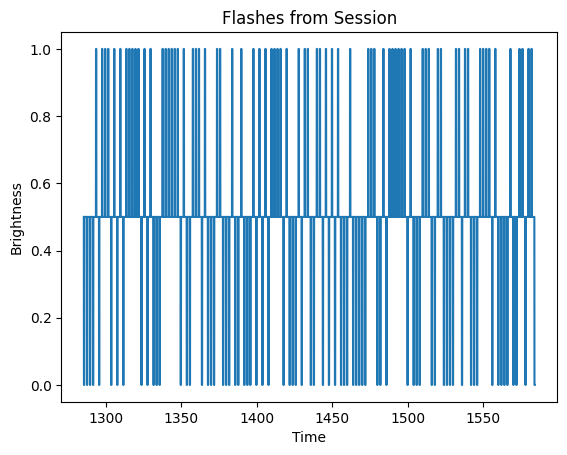

In [21]:
start_time = np.min(flashes_table.start_time)
end_time = np.max(flashes_table.stop_time)
time_axis = np.linspace(start_time, end_time, num=int((end_time-start_time)//bin_sz), endpoint=False)

print("start:",start_time,"end:",end_time)
print(len(time_axis))

interp_flashes = np.zeros(len(time_axis))
table_idx = 0
for i, ts in enumerate(time_axis):
    if ts > flashes_table.start_time[table_idx] and ts < flashes_table.stop_time[table_idx]:
        if float(flashes_table.color[table_idx]) == 1.0:
            interp_flashes[i] = 1.0
        elif float(flashes_table.color[table_idx]) == -1.0:
            interp_flashes[i] = -1
    elif ts < flashes_table.start_time[table_idx]:
        continue
    while ts > flashes_table.stop_time[table_idx]:
        table_idx += 1

norm_flashes = (interp_flashes + 1) / 2

plt.plot(time_axis, norm_flashes)
plt.title("Flashes from Session")
plt.xlabel("Time")
plt.ylabel("Brightness")

### Generating Filters
As with the synthetic data above, the design matrix is generated from the stimulus flashes. The filter length is set to 500 ms. Then, we train a GLM filter for each unit.  

(11939, 21)


Text(0, 0.5, 'Current Time (through session)')

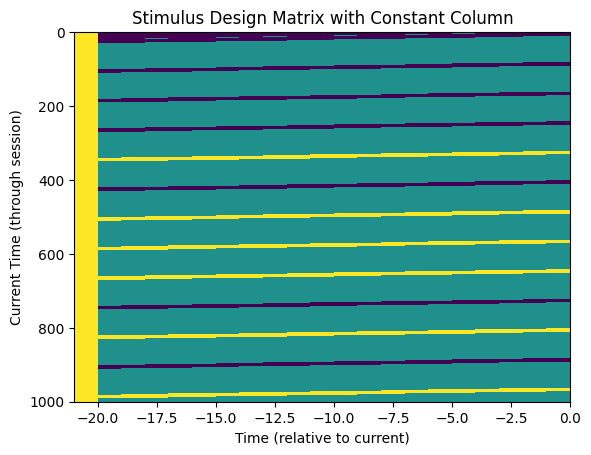

In [22]:
filter_length = int(0.5 / bin_sz) # we want a 500 ms window, specified in # of bins
design_mat = build_design_mat(norm_flashes, d=filter_length)
print(design_mat.shape)

plt.imshow(design_mat[:1000], extent=[-design_mat.shape[1], 0, 1000, 0], aspect="auto", interpolation="none")
plt.title("Stimulus Design Matrix with Constant Column")
plt.xlabel("Time (relative to current)")
plt.ylabel("Current Time (through session)")

In [23]:
training_outputs = []
for i, spike_times in enumerate(units_spike_times):
    # bin spikes where bins line up with the interpolated flashes timestamps
    these_spikes_binned, _ = np.histogram(spike_times, bins=len(time_axis), range=(start_time,end_time))
    try:
        res = fit_lnp(design_mat, these_spikes_binned, d=filter_length, lam=2**6)
        const, filt = res[0], res[1:]
        training_outputs.append((these_spikes_binned, const, filt))
    except:
        training_outputs.append((these_spikes_binned, np.nan, []))

y: (11939,) X: (11939, 21) x0: (21,)
y: (11939,) X: (11939, 21) x0: (21,)
y: (11939,) X: (11939, 21) x0: (21,)
y: (11939,) X: (11939, 21) x0: (21,)
y: (11939,) X: (11939, 21) x0: (21,)
y: (11939,) X: (11939, 21) x0: (21,)
y: (11939,) X: (11939, 21) x0: (21,)
y: (11939,) X: (11939, 21) x0: (21,)
y: (11939,) X: (11939, 21) x0: (21,)
y: (11939,) X: (11939, 21) x0: (21,)
y: (11939,) X: (11939, 21) x0: (21,)
y: (11939,) X: (11939, 21) x0: (21,)
y: (11939,) X: (11939, 21) x0: (21,)
y: (11939,) X: (11939, 21) x0: (21,)
y: (11939,) X: (11939, 21) x0: (21,)
y: (11939,) X: (11939, 21) x0: (21,)
y: (11939,) X: (11939, 21) x0: (21,)
y: (11939,) X: (11939, 21) x0: (21,)
y: (11939,) X: (11939, 21) x0: (21,)
y: (11939,) X: (11939, 21) x0: (21,)
y: (11939,) X: (11939, 21) x0: (21,)
y: (11939,) X: (11939, 21) x0: (21,)
y: (11939,) X: (11939, 21) x0: (21,)
y: (11939,) X: (11939, 21) x0: (21,)
y: (11939,) X: (11939, 21) x0: (21,)
y: (11939,) X: (11939, 21) x0: (21,)
y: (11939,) X: (11939, 21) x0: (21,)
y

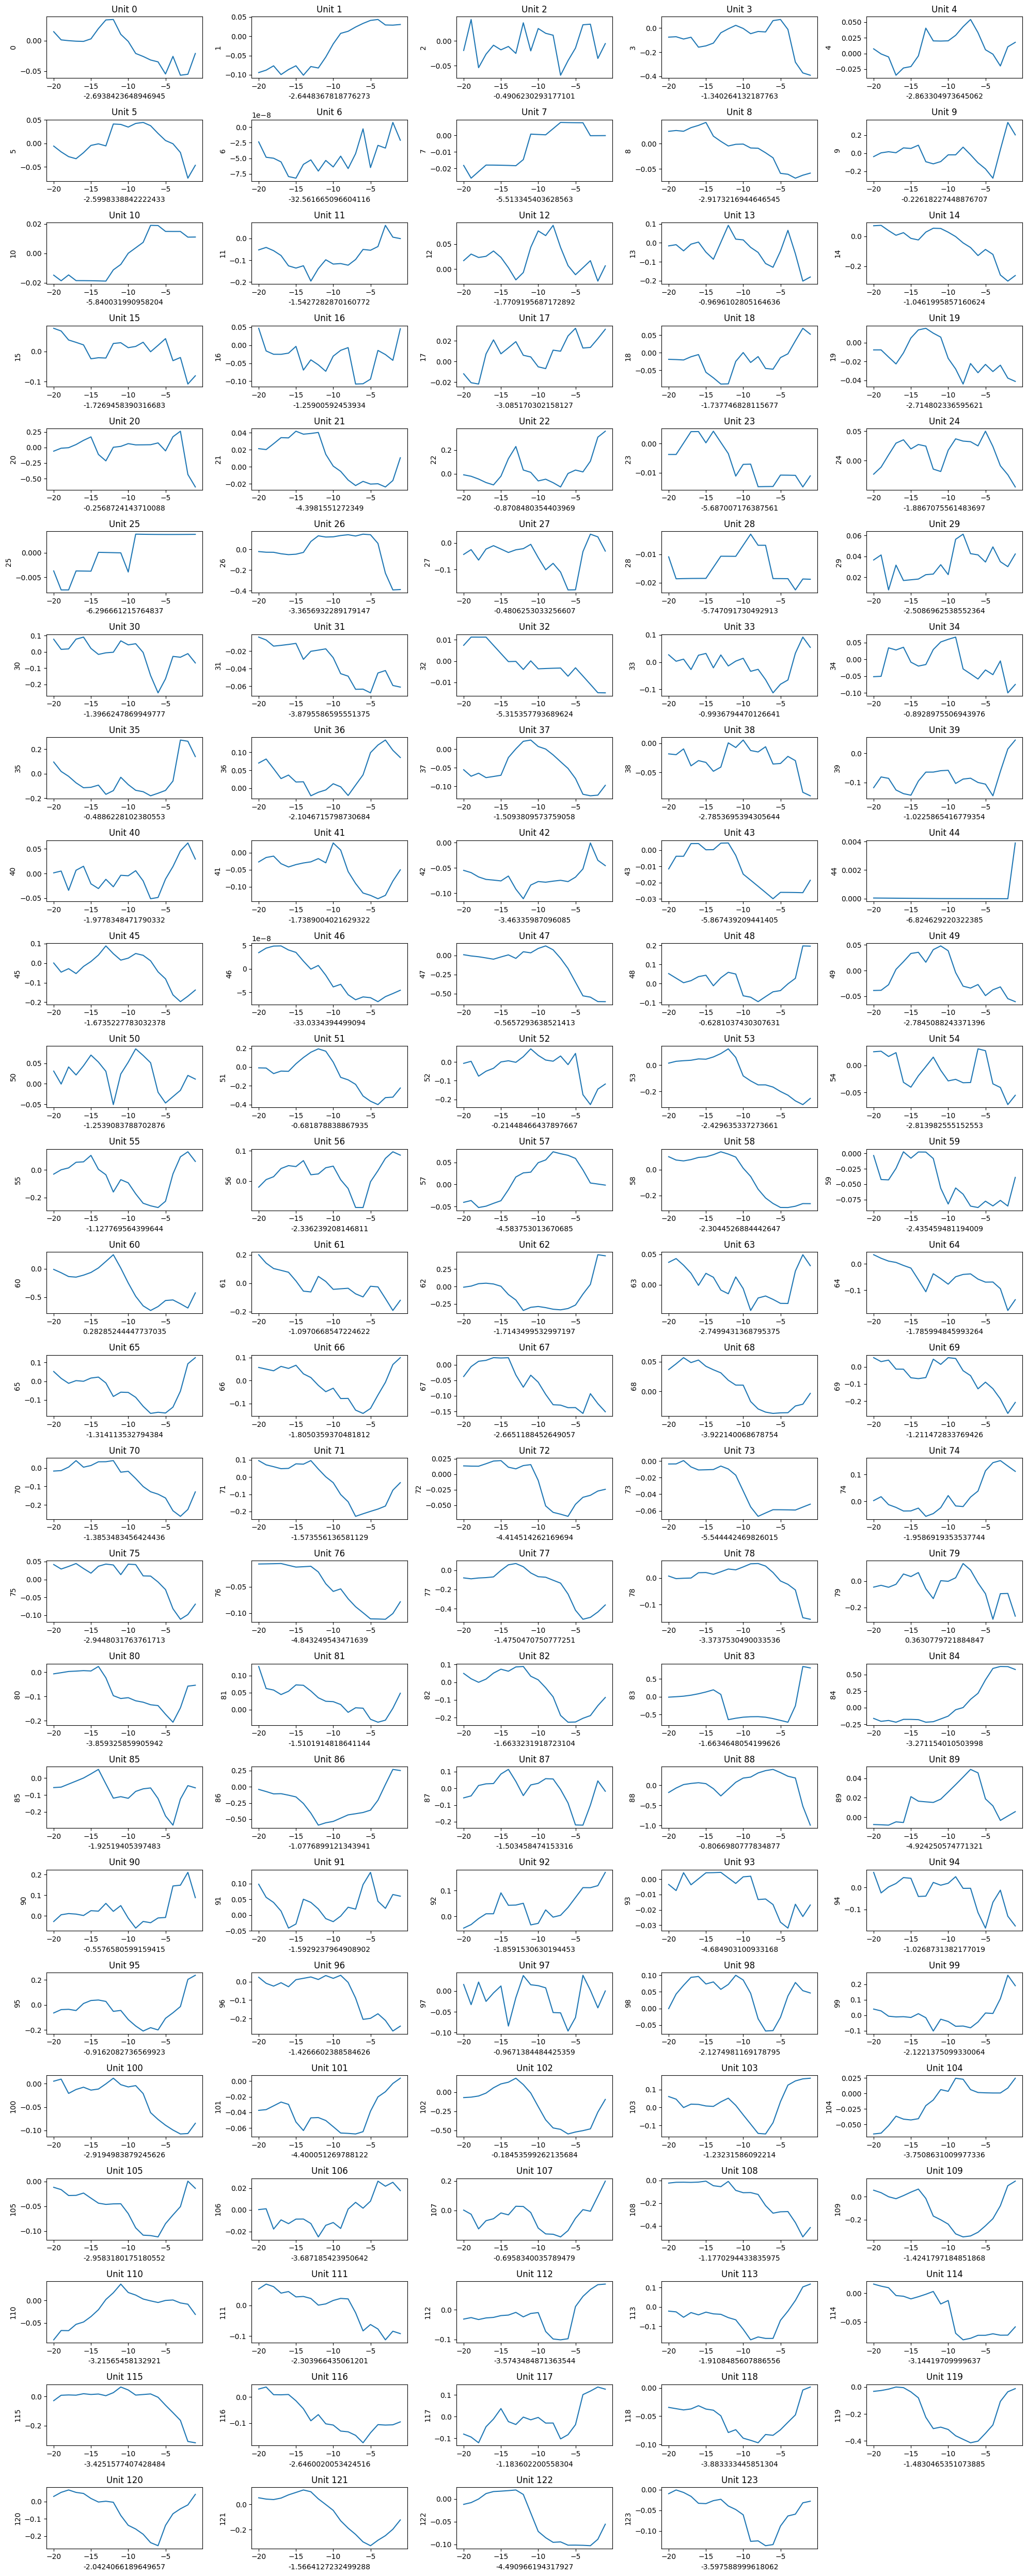

In [24]:
n_cols=5

n_rows = ceil(len(training_outputs)/n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20,2*n_rows))
if len(axes.shape) == 1:
    axes = axes.reshape((1, axes.shape[0]))

for i, ax in enumerate(axes.flatten()):
    if i >= len(training_outputs):
        ax.set_visible(False)
        continue
    _, const, filt = training_outputs[i]
    ax.plot(range(-len(filt),0), filt)
    ax.set_ylabel(i)
    ax.set_xlabel(const)
    ax.set_title(f"Unit {i}")

fig.tight_layout()
plt.show()

### Predict Activity
Finally, these trained filters can be applied to the stimulus to generate predicted spiking probability and predicted spike counts. In a real use case, one could provide some hypothetical stimulus values to predict how the units of interest may respond. Note that since the Poisson generation is non-deterministic, the predicted spikes will differ with each run. To evaluate the GLM's performance, the $R^2$ values are calculated between the observed spikes and the predicted spike probability.

In [25]:
prediction_outputs = []
for spikes_binned, constant, filter in training_outputs:
    predicted_rate = predict(design_mat[:,1:], filter, constant)
    spikes_predicted = predict_spikes(design_mat[:,1:], filter, constant)
    r2 = r2_score(spikes_binned, predicted_rate)

    print("===")
    print("observed mean rate:", np.sum(spikes_binned) / len(spikes_binned))
    print("predicted mean rate:", np.sum(spikes_predicted) / len(spikes_predicted))
    print("loss:",r2)

    prediction_outputs.append([predicted_rate, spikes_predicted, r2])

r2s = np.array([output[2] for output in prediction_outputs])
print("average loss:",np.mean(r2s))

===
observed mean rate: 0.06080911299103778
predicted mean rate: 0.0573749895301114
loss: 0.000530857231021642
===
observed mean rate: 0.05285199765474495
predicted mean rate: 0.05410838428679119
loss: 0.002831639297435906
===
observed mean rate: 0.5694781807521568
predicted mean rate: 0.5742524499539325
loss: 0.000627520414711813
===
observed mean rate: 0.10930563698802245
predicted mean rate: 0.11039450540246251
loss: 0.019787499793137653
===
observed mean rate: 0.06281933160231175
predicted mean rate: 0.06725856436887512
loss: 0.00033174783982237166
===
observed mean rate: 0.07488064326995561
predicted mean rate: 0.07203283357065081
loss: 0.0005764294855618024
===
observed mean rate: 0.0
predicted mean rate: 0.0
loss: 0.0
===
observed mean rate: 0.003769159896138705
predicted mean rate: 0.0045229918753664465
loss: 7.450951207954581e-05
===
observed mean rate: 0.04975291062903091
predicted mean rate: 0.05109305636988022
loss: 0.000487422411888927
===
observed mean rate: 0.76949493257

Text(0, 0.5, '# Units')

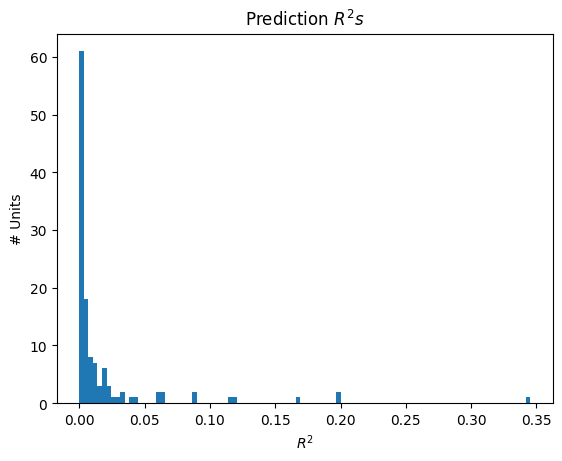

In [26]:
plt.hist(r2s, bins=100)
plt.title("Prediction $R^2s$")
plt.xlabel("$R^2$")
plt.ylabel("# Units")

In [27]:
best_fits = r2s > 0.05
best_training_outputs = np.array(training_outputs, dtype=object)[best_fits]
best_prediction_outputs = np.array(prediction_outputs, dtype=object)[best_fits]

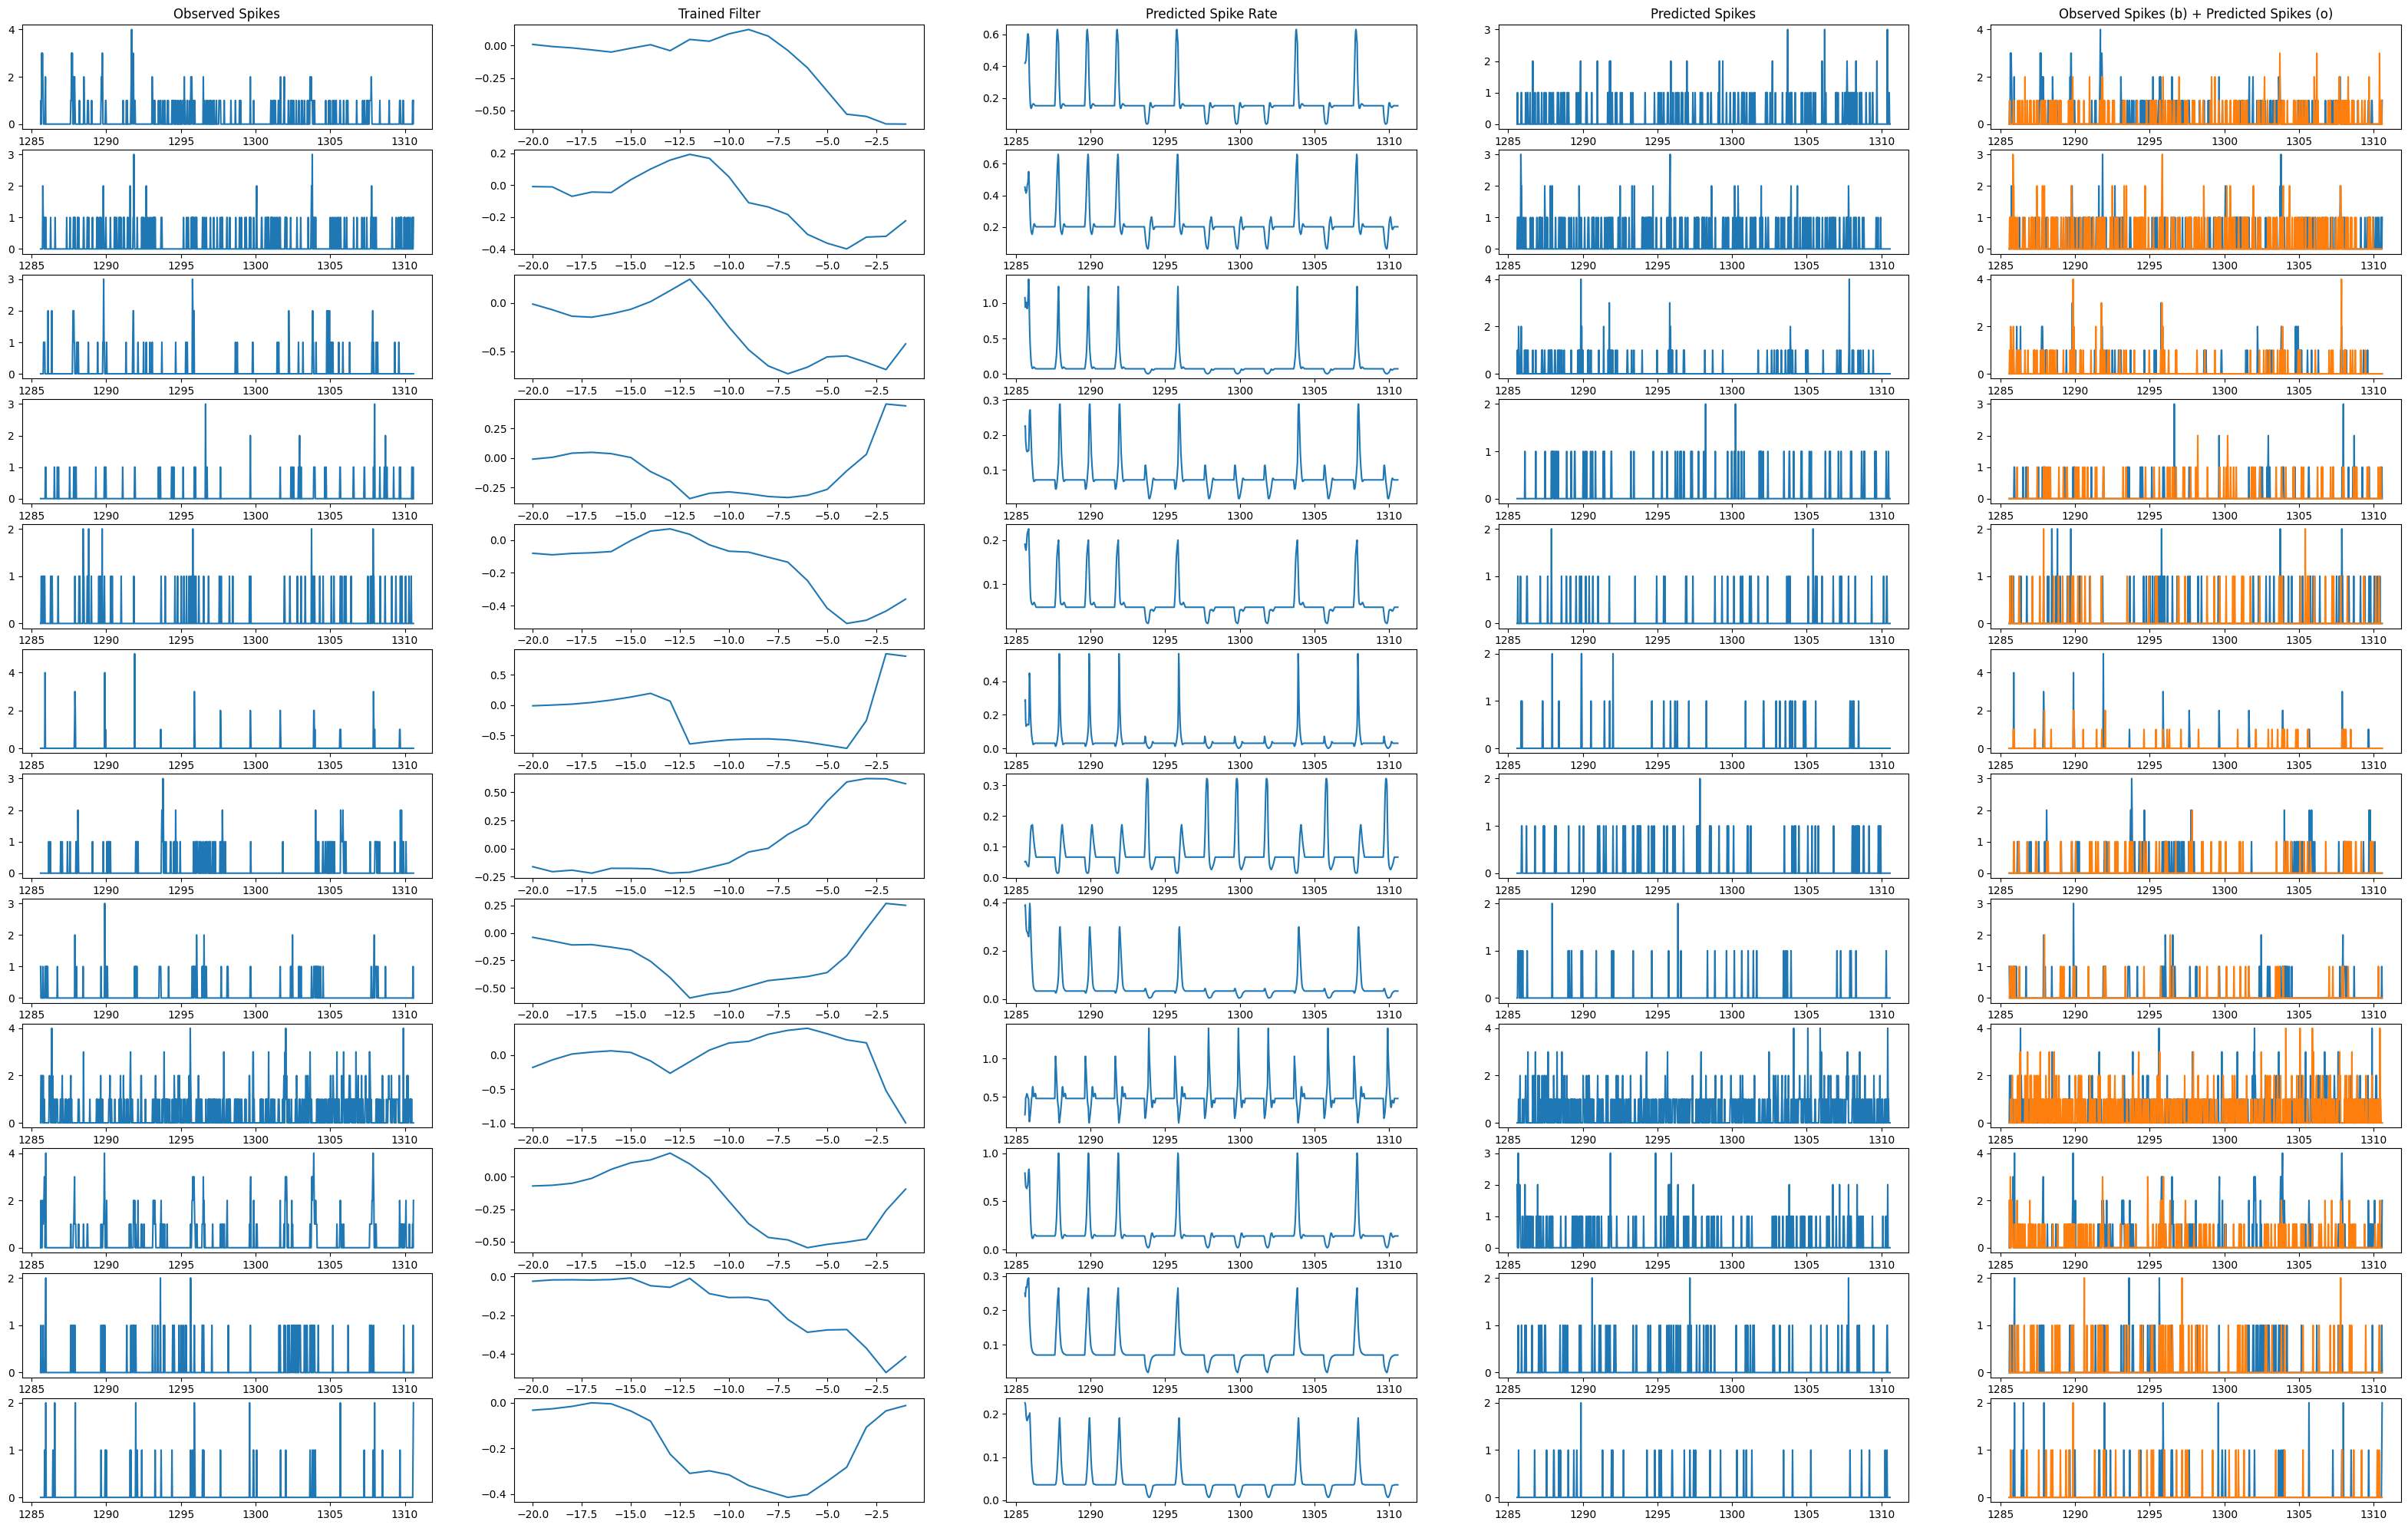

In [28]:
n_cells = len(best_training_outputs)
fig, axes = plt.subplots(n_cells, 5, figsize=(40,2*n_cells+1))

for i in range(len(best_training_outputs)):
    spikes_binned, constant, filter = best_training_outputs[i]
    predicted_rate, spikes_predicted, r2 = best_prediction_outputs[i]

    time_range_start = 0
    time_range_end = 1000
    axes[i][0].plot(time_axis[time_range_start:time_range_end], spikes_binned[time_range_start:time_range_end])
    axes[i][1].plot(range(-len(filter), 0), filter)
    axes[i][2].plot(time_axis[time_range_start:time_range_end], predicted_rate[time_range_start:time_range_end])
    axes[i][3].plot(time_axis[time_range_start:time_range_end], spikes_predicted[time_range_start:time_range_end])
    axes[i][4].plot(time_axis[time_range_start:time_range_end], spikes_binned[time_range_start:time_range_end])
    axes[i][4].plot(time_axis[time_range_start:time_range_end], spikes_predicted[time_range_start:time_range_end])

axes[0][0].set_title("Observed Spikes")
axes[0][1].set_title("Trained Filter")
axes[0][2].set_title("Predicted Spike Rate")
axes[0][3].set_title("Predicted Spikes")
axes[0][4].set_title("Observed Spikes (b) + Predicted Spikes (o)")

plt.show()

### Comparing to Z-Scores

In [29]:
# start and end times (relative to the stimulus at 0 seconds) that we want to examine and align spikes to
window_start_time = -0.25
window_end_time = 0.25

In [30]:
def get_spike_matrix(stim_times, units_spike_times, bin_edges, bin_sz):
    n_units = len(units_spike_times)
    n_trials = len(stim_times)

    # 3D spike matrix to be populated with spike counts
    spike_matrix = np.zeros((n_units, len(bin_edges), n_trials))

    # populate 3D spike matrix for each unit for each stimulus trial by counting spikes into bins
    for unit_idx in range(n_units):
        spike_times = units_spike_times[unit_idx]

        for stim_idx, stim_time in enumerate(stim_times):
            # get spike times that fall within the bin's time range relative to the stim time        
            first_bin_time = stim_time + bin_edges[0]
            last_bin_time = stim_time + bin_edges[-1]
            first_spike_in_range, last_spike_in_range = np.searchsorted(spike_times, [first_bin_time, last_bin_time])
            spike_times_in_range = spike_times[first_spike_in_range:last_spike_in_range]

            # convert spike times into relative time bin indices
            bin_indices = ((spike_times_in_range - (first_bin_time)) / bin_sz).astype(int)
            
            # mark that there is a spike at these bin times for this unit on this stim trial
            for bin_idx in bin_indices:
                spike_matrix[unit_idx, bin_idx, stim_idx] += 1

    spike_matrix = spike_matrix.swapaxes(1,2)
    return spike_matrix

In [31]:
white_flash_times = time_axis[[i for i in range(1,len(norm_flashes)) if norm_flashes[i] == 1.0 and norm_flashes[i-1] == 0.5]]
black_flash_times = time_axis[[i for i in range(1,len(norm_flashes)) if norm_flashes[i] == 0.0 and norm_flashes[i-1] == 0.5]]

# time bins used
n_bins = int((window_end_time - window_start_time) / bin_sz)
bin_edges = np.linspace(window_start_time, window_end_time, n_bins, endpoint=True)

# calculate baseline and stimulus interval indices for use later
stimulus_onset_idx = int(-bin_edges[0] / bin_sz)

white_flash_responses = get_spike_matrix(white_flash_times, units_spike_times, bin_edges, bin_sz)
black_flash_responses = get_spike_matrix(black_flash_times, units_spike_times, bin_edges, bin_sz)

# has shape neuro * trials * time
print(white_flash_responses.shape)
print(black_flash_responses.shape)

(124, 75, 20)
(124, 75, 20)


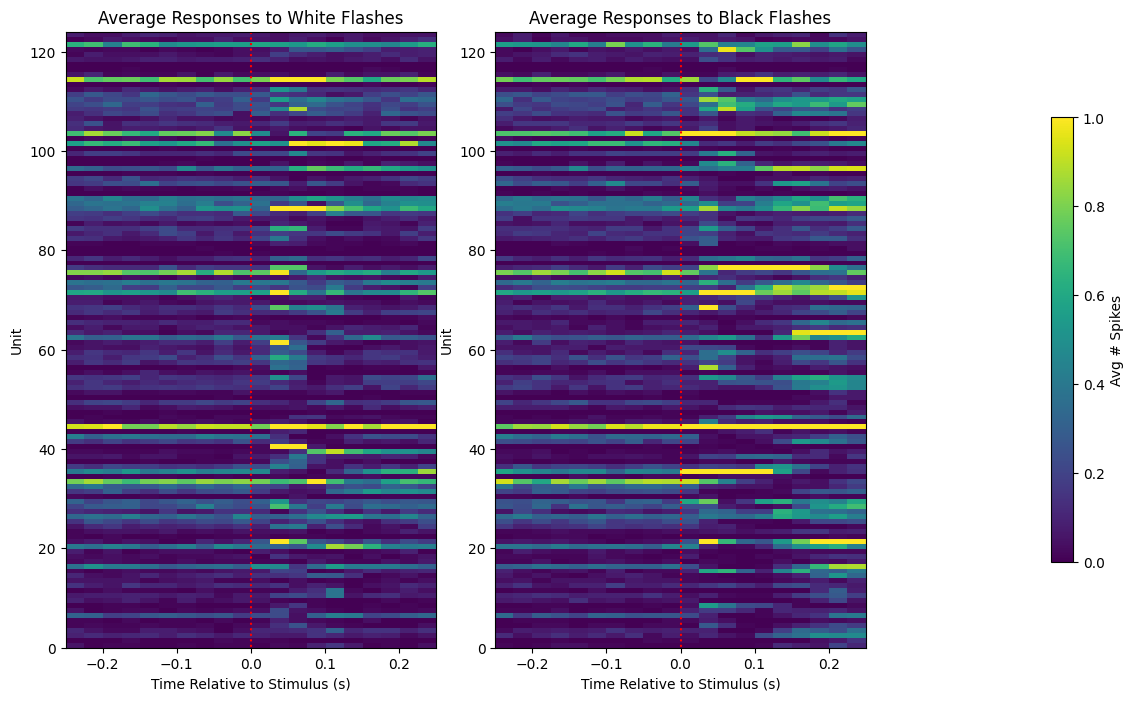

In [32]:
fig, axes = plt.subplots(1, 3, figsize=(13,8), gridspec_kw={"width_ratios":[1,1,0.4]})
vmax = 1
axes[0].imshow(np.mean(white_flash_responses, axis=1), vmax=vmax, extent=[bin_edges[0], bin_edges[-1], 0, len(units_spike_times)], aspect="auto")
axes[0].vlines(0, white_flash_responses.shape[0], 0, colors="r", ls=":")
axes[0].set_title("Average Responses to White Flashes")
axes[0].set_xlabel("Time Relative to Stimulus (s)")
axes[0].set_ylabel("Unit")

img = axes[1].imshow(np.mean(black_flash_responses, axis=1), vmax=vmax, extent=[bin_edges[0], bin_edges[-1], 0, len(units_spike_times)], aspect="auto")
axes[1].vlines(0, black_flash_responses.shape[0], 0, colors="r", ls=":")
axes[1].set_title("Average Responses to Black Flashes")
axes[1].set_xlabel("Time Relative to Stimulus (s)")
axes[1].set_ylabel("Unit")

cbar = fig.colorbar(img, ax=axes[2])
axes[2].set_visible(False)
cbar.set_label("Avg # Spikes")

In [33]:
def get_zscore_mat(spike_matrix, stimulus_onset_idx):
    baseline_rates = np.mean(spike_matrix[:,:,:stimulus_onset_idx], axis=2)
    baseline_stds = np.std(spike_matrix[:,:,:stimulus_onset_idx], axis=2)

    mean_baseline_rate = np.expand_dims(np.mean(baseline_rates, axis=1), 1)
    mean_baseline_stds = np.expand_dims(np.mean(baseline_stds, axis=1), 1) + 0.1 # to prevent division by 0

    zscores = (np.mean(spike_matrix, axis=1) - mean_baseline_rate) / mean_baseline_stds
    return zscores

white_flash_zscores = get_zscore_mat(white_flash_responses, stimulus_onset_idx)
black_flash_zscores = get_zscore_mat(black_flash_responses, stimulus_onset_idx)

print(white_flash_zscores.shape)
print(black_flash_zscores.shape)

(124, 20)
(124, 20)


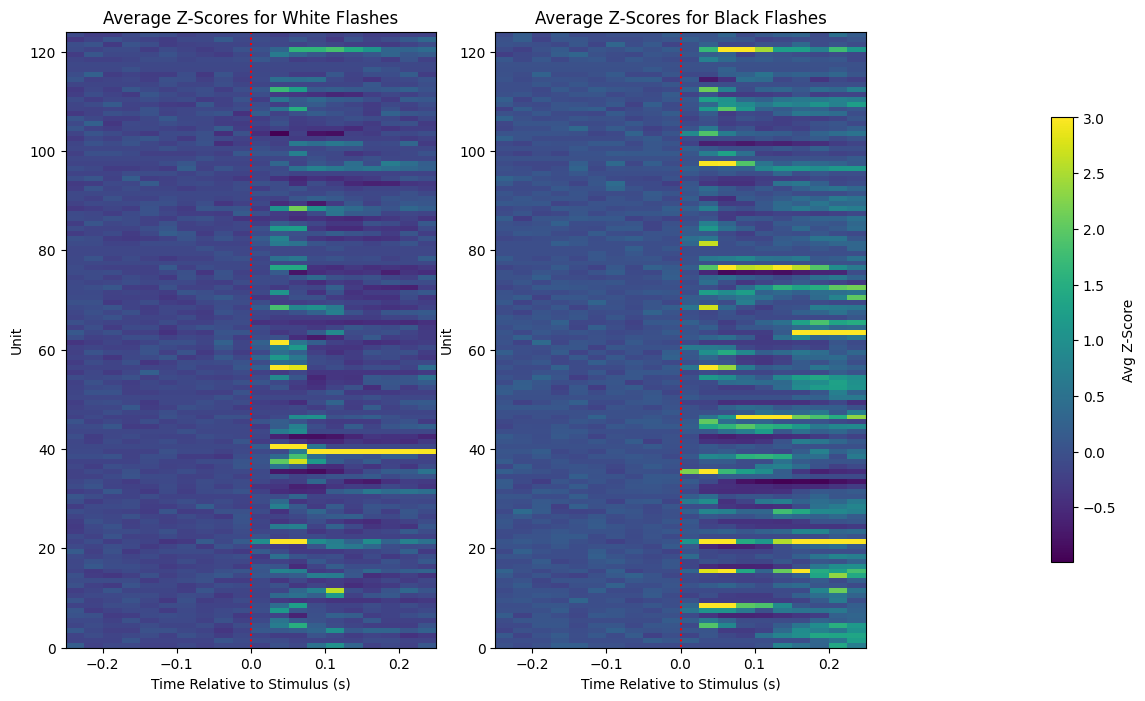

In [34]:
fig, axes = plt.subplots(1, 3, figsize=(13,8), gridspec_kw={"width_ratios":[1,1,0.4]})
vmax=3
axes[0].imshow(white_flash_zscores, vmax=vmax, extent=[bin_edges[0], bin_edges[-1], 0, len(units_spike_times)], aspect="auto")
axes[0].vlines(0, white_flash_zscores.shape[0], 0, colors="r", ls=":")
axes[0].set_title("Average Z-Scores for White Flashes")
axes[0].set_xlabel("Time Relative to Stimulus (s)")
axes[0].set_ylabel("Unit")

img = axes[1].imshow(black_flash_zscores, vmax=vmax, extent=[bin_edges[0], bin_edges[-1], 0, len(units_spike_times)], aspect="auto")
axes[1].vlines(0, black_flash_zscores.shape[0], 0, colors="r", ls=":")
axes[1].set_title("Average Z-Scores for Black Flashes")
axes[1].set_xlabel("Time Relative to Stimulus (s)")
axes[1].set_ylabel("Unit")

cbar = fig.colorbar(img, ax=axes[2])
axes[2].set_visible(False)
cbar.set_label("Avg Z-Score")

In [35]:
# pick top 10 most responsive units
white_max_zscores = np.max(white_flash_zscores[:,stimulus_onset_idx:], axis=1)
top_white_units = np.nonzero(white_max_zscores > 2)[0]
top_white_zscores = white_flash_zscores[top_white_units]

black_max_zscores = np.max(black_flash_zscores[:,stimulus_onset_idx:], axis=1)
top_black_units = np.nonzero(black_max_zscores > 2)[0]
top_black_zscores = black_flash_zscores[top_black_units]


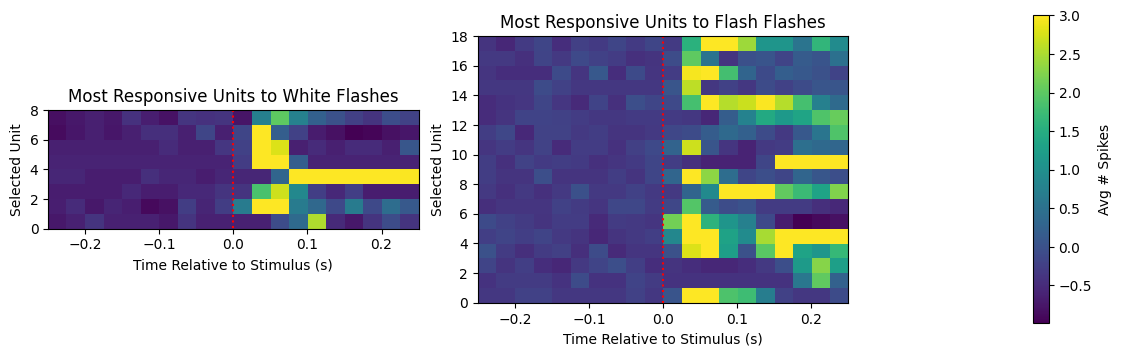

In [36]:
fig, axes = plt.subplots(1, 3, figsize=(13,4), gridspec_kw={"width_ratios":[1,1,0.4]})

axes[0].imshow(top_white_zscores, vmax=3, extent=[bin_edges[0], bin_edges[-1], 0, len(top_white_units)], aspect=0.02)
axes[0].vlines(0, top_white_zscores.shape[0], 0, colors="r", ls=":")
axes[0].set_title("Most Responsive Units to White Flashes")
axes[0].set_xlabel("Time Relative to Stimulus (s)")
axes[0].set_ylabel("Selected Unit")
axes[1].imshow(top_black_zscores, vmax=3, extent=[bin_edges[0], bin_edges[-1], 0, len(top_black_units)], aspect=0.02)
axes[1].vlines(0, top_black_zscores.shape[0], 0, colors="r", ls=":")
axes[1].set_title("Most Responsive Units to Flash Flashes")
axes[1].set_xlabel("Time Relative to Stimulus (s)")
axes[1].set_ylabel("Selected Unit")

cbar = fig.colorbar(img, ax=axes[2])
axes[2].set_visible(False)
cbar.set_label("Avg # Spikes")

In [37]:
print("Units most responsive to white flashes:", np.sort(top_white_units))
print("Units most responsive to black flashes:", np.sort(top_black_units))
print("Units that produced best fitting GLMs:", np.nonzero(best_fits)[0])

Units most responsive to white flashes: [ 35  62  67  83  84  86 102 112]
Units most responsive to black flashes: [  3  11  26  42  47  51  53  55  60  67  77  78  88 102 108 109 112 115]
Units that produced best fitting GLMs: [ 47  51  60  62  77  83  84  86  88 102 108 119]


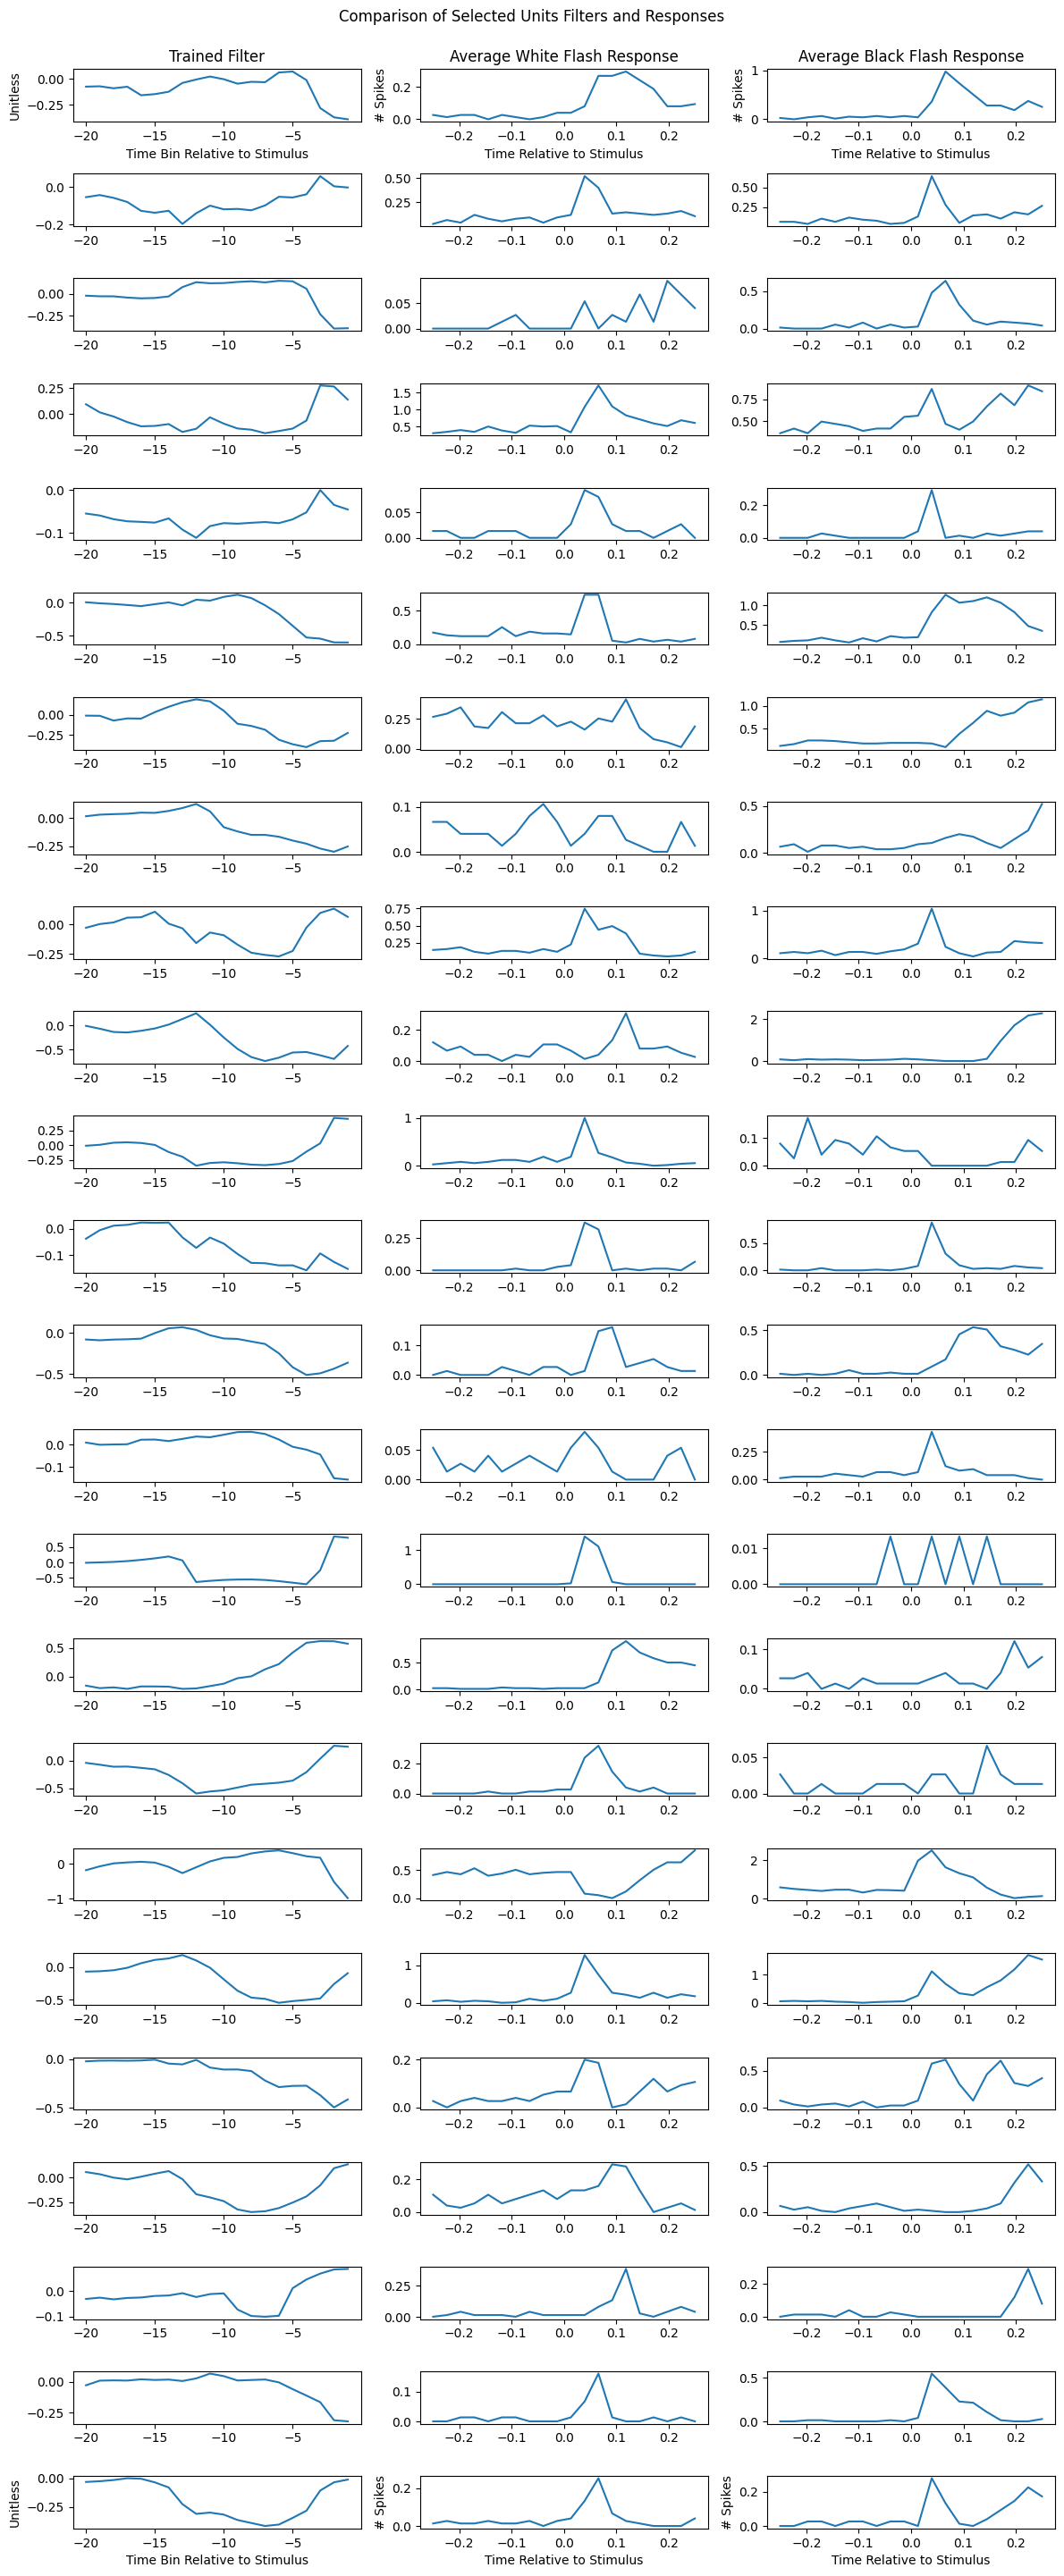

In [38]:
units_of_interest = reduce(np.union1d, (top_white_units, top_black_units, np.nonzero(best_fits)[0]))
units_of_interest

fig, axes = plt.subplots(len(units_of_interest), 3, figsize=(12,1.2*len(units_of_interest)))
for i, unit_id in enumerate(units_of_interest):
    spikes_binned, constant, filter = training_outputs[unit_id]
    mean_white_response = np.mean(white_flash_responses[unit_id], axis=0)
    mean_black_response = np.mean(black_flash_responses[unit_id], axis=0)

    axes[i][0].plot(range(-len(filter),0), filter)
    axes[i][1].plot(bin_edges, mean_white_response)
    axes[i][2].plot(bin_edges, mean_black_response)

for ax_x, ax_y in ((0,1),(0,2),(-1,1),(-1,2)):
    axes[ax_x][ax_y].set_xlabel("Time Relative to Stimulus")

for ax_x, ax_y in ((0,0), (-1,0)):
    axes[ax_x][ax_y].set_xlabel("Time Bin Relative to Stimulus")

axes[0][0].set_ylabel("Unitless")
axes[-1][0].set_ylabel("Unitless")
axes[0][1].set_ylabel("# Spikes")
axes[-1][1].set_ylabel("# Spikes")
axes[0][2].set_ylabel("# Spikes")
axes[-1][2].set_ylabel("# Spikes")

axes[0][0].set_title("Trained Filter")
axes[0][1].set_title("Average White Flash Response")
axes[0][2].set_title("Average Black Flash Response")
fig.suptitle("Comparison of Selected Units Filters and Responses", y=0.999)
fig.tight_layout()